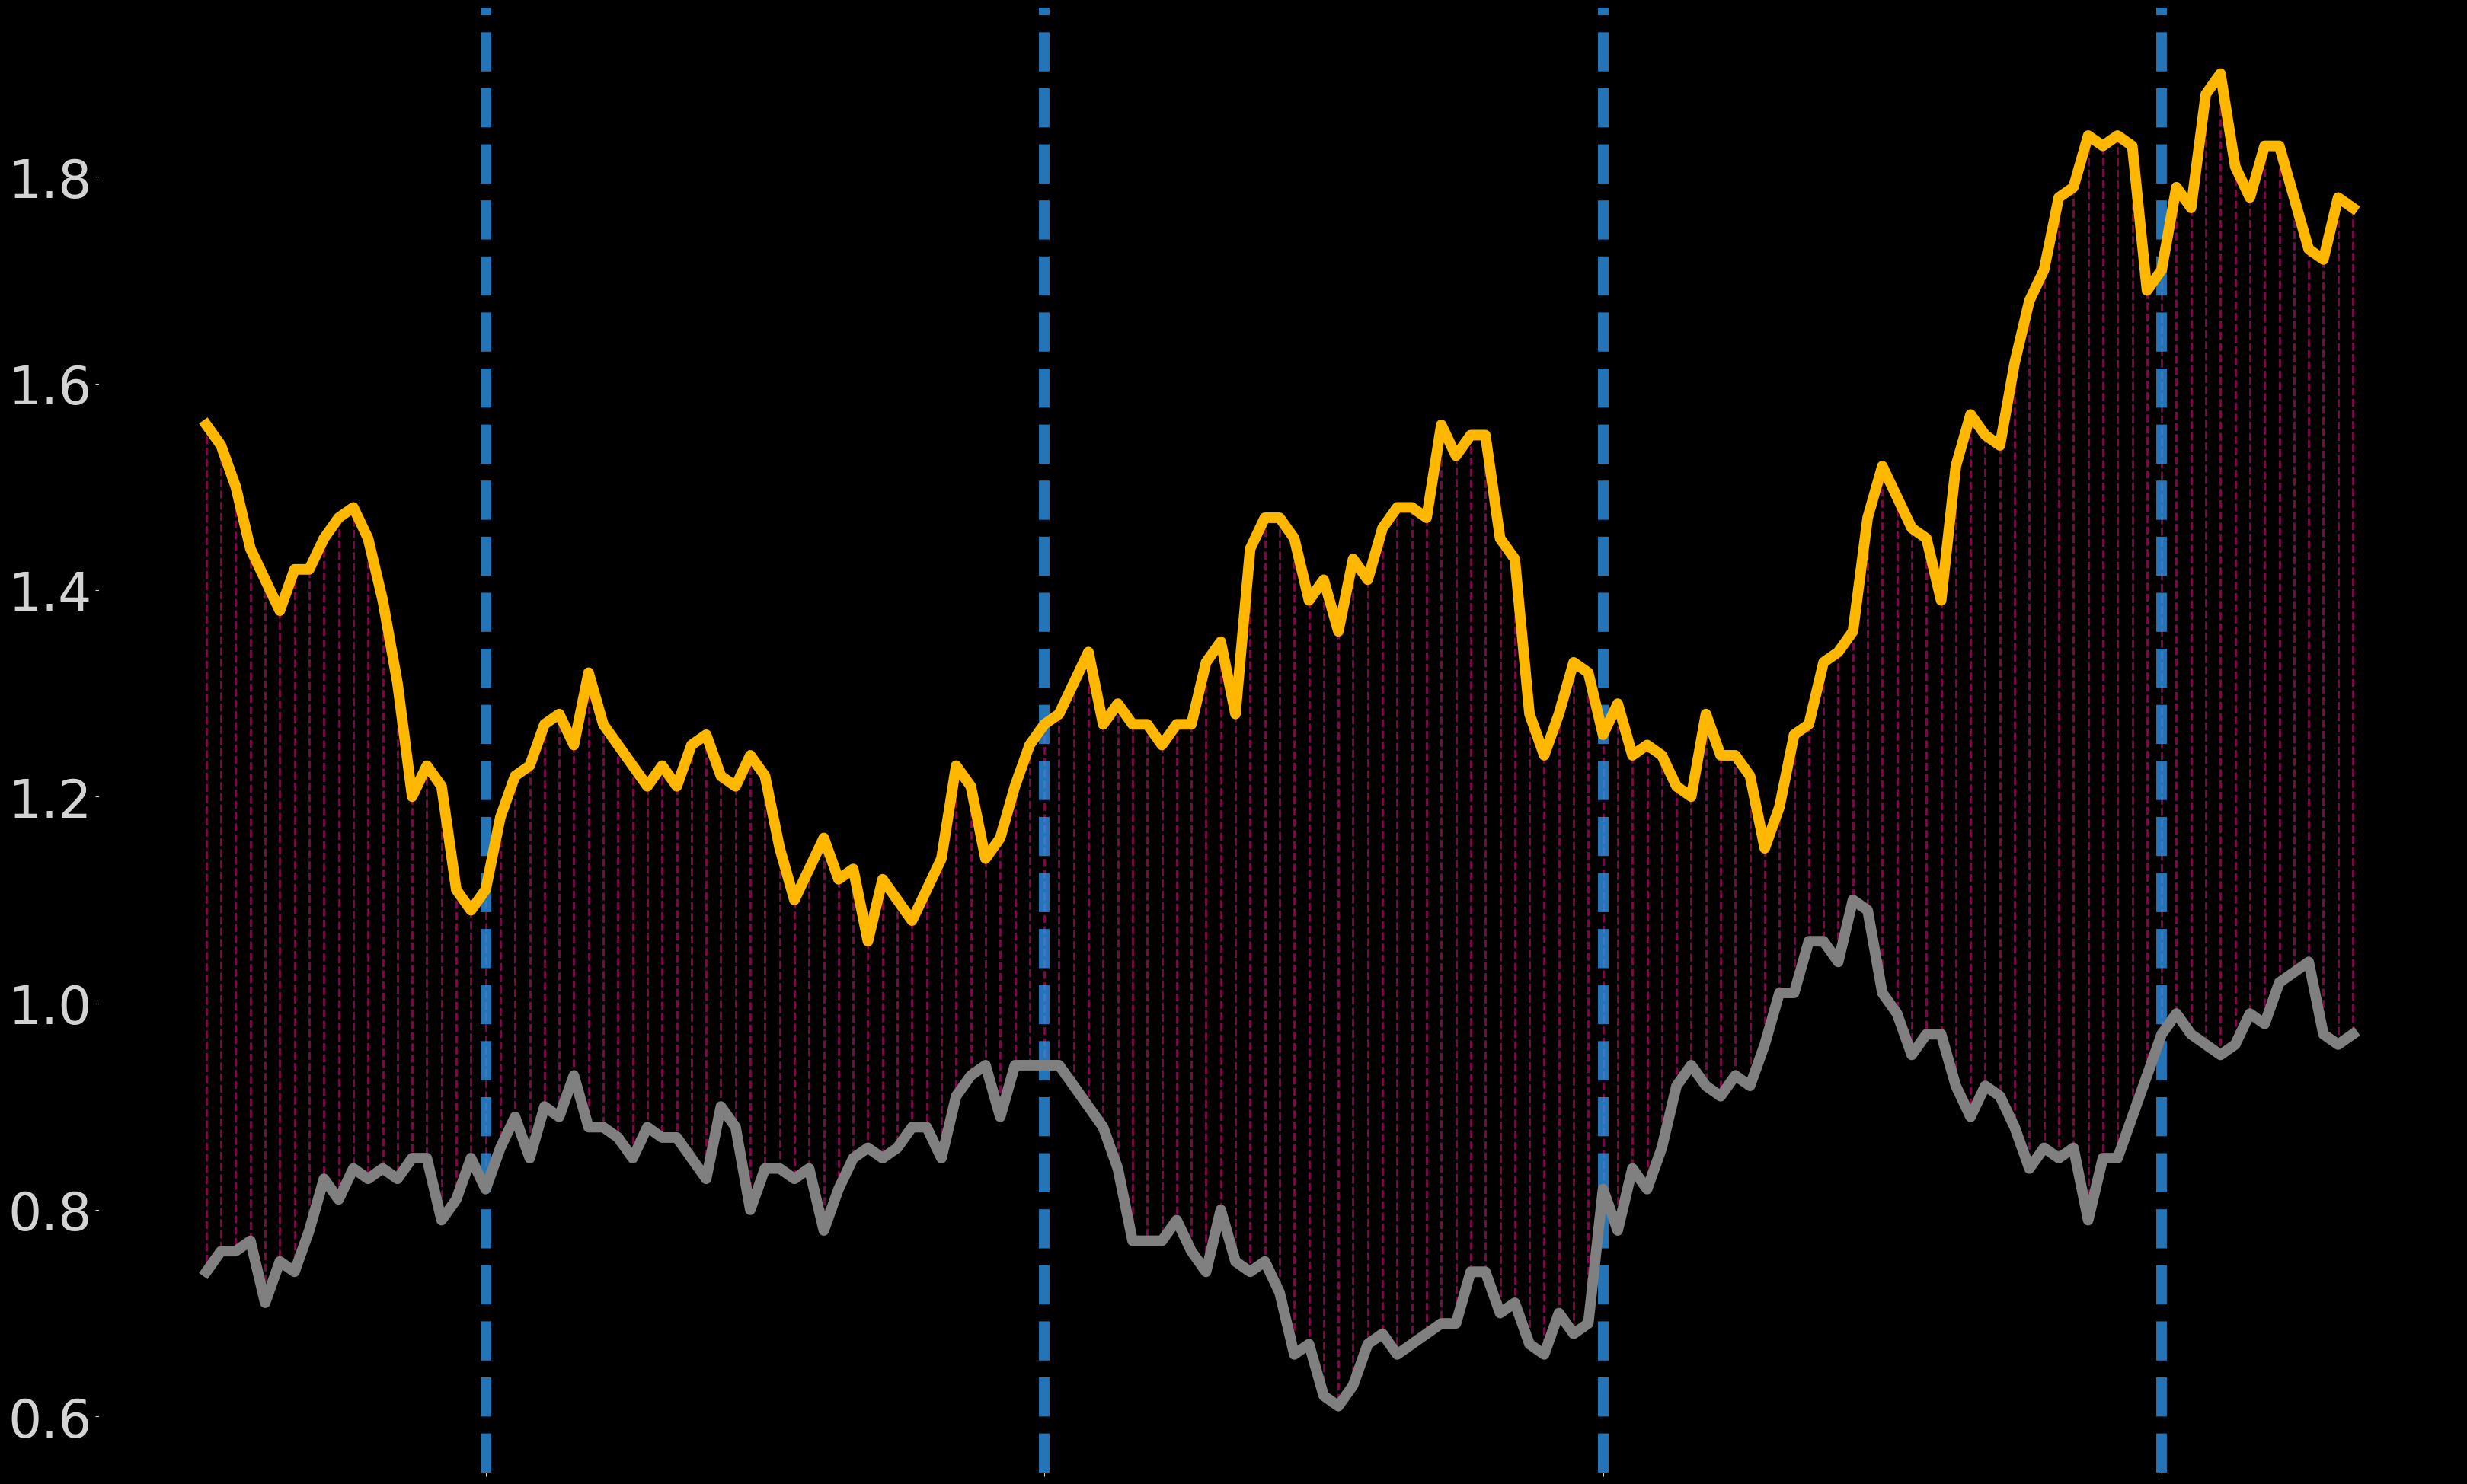

In [2]:
# Import necessary libraries
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

# Set team-specific information
team = 'Atletico-Madrid'
team_id = 'db3b9613'

# Define seasons of interest
seasons = ['2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024']

# List to store DataFrames for each season
merged_dfs = []

# Loop through each season
for season in seasons:
    # Construct the URL for the team's match logs on FBref
    url = "https://fbref.com/en/squads/"+team_id+"/"+season+"/matchlogs/c12/shooting/"+team+"-Match-Logs-La-Liga"
    
    # Retrieve and process data for the team
    for_team = pd.read_html(url, index_col=[0,1])[0]
    for_team.columns = for_team.columns.droplevel(0)
    for_team = for_team.iloc[:-1]
    for_team = for_team.to_csv("tempforteam.csv")
    time.sleep(5)
    for_team = pd.read_csv("tempforteam.csv")
    for_team.rename(columns={for_team.columns[0]: 'Date', for_team.columns[1]: 'Time'}, inplace=True)

    # Retrieve and process data for the opponents
    against_team = pd.read_html(url, index_col=[0,1])[1]
    against_team.columns = against_team.columns.droplevel(0)
    against_team = against_team.iloc[:-1]
    against_team = against_team.to_csv("tempagainstteam.csv")
    time.sleep(5)
    against_team = pd.read_csv("tempagainstteam.csv")
    against_team.rename(columns={against_team.columns[0]: 'Date', against_team.columns[1]: 'Time'}, inplace=True)

    # Merge the data for the team and opponents based on common columns
    merged_df = pd.merge(for_team, against_team, on=['Date', 'Round', 'Opponent'], how='inner', suffixes=('_for', '_against'))
    merged_df = merged_df[['Date', 'Round', 'Opponent', 'npxG_for', 'npxG_against']]
    merged_dfs.append(merged_df)

# Concatenate all DataFrames for different seasons into a single DataFrame
df = pd.concat(merged_dfs, ignore_index=True)

# Add a 'Match' column to represent the match number
df['Match'] = df.index + 1

# Calculate rolling averages for expected goals (xG) for and against the team
df['xG_rolling'] = df['npxG_for'].rolling(window=19).mean()
df['xGA_rolling'] = df['npxG_against'].rolling(window=19).mean()

# Round values in the DataFrame to two decimal places
df = df.round(2)

# Define colors for plotting
season_divider_clr = '#2f9df7'
xg_clr = '#ffb700'
xga_clr = 'grey'
connector_clr = 'deeppink'

# Create a large black background figure for the plot
fig = plt.figure(figsize=(40, 25), facecolor='black')
ax = plt.axes()
ax.set_facecolor("black")

# Add grid lines for seasons with a specific color
ax.xaxis.grid(color=season_divider_clr, linestyle='--', linewidth=10, alpha=.75, zorder=1)

# Hide x-axis ticks and customize tick parameters
plt.xticks(np.arange(0, 166, 38), [])
ax.tick_params(axis='x', colors='lightgrey')
ax.tick_params(axis='y', colors='lightgrey')

# Customize matplotlib parameters for better visualization
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['font.size'] = 50
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['lines.linewidth'] = '10'

# Plot the rolling averages for xG and xGA
plt.plot(df.Match, df.xG_rolling, color=xg_clr)
plt.plot(df.Match, df.xGA_rolling, color=xga_clr)

# Plot connecting lines between xG and xGA for each match
for match, xg, xga in zip(df.Match, df.xG_rolling, df.xGA_rolling):
    plt.plot([match, match], [xg, xga], color=connector_clr, linestyle='--', linewidth=2, alpha=.5, zorder=1)

# Save the plot as an image file
plt.savefig(team + '-RollingXg.png', bbox_inches='tight')